# Переобучение

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
])
path = './MNIST_data'
batch_size = 32

Выгрузим данные и загрузим их в DataLoader.  

In [3]:
train_data = datasets.MNIST(path, train=True,
                            download=True, transform=mnist_transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = datasets.MNIST(path, train=False,
                           download=True, transform=mnist_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 117288795.60it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40071350.92it/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36979816.90it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6088376.08it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

Посмотрим на размерность 1-го сэмпла.  

In [5]:
example_data.shape

torch.Size([32, 1, 28, 28])

Посмотрим на сами примеры.  

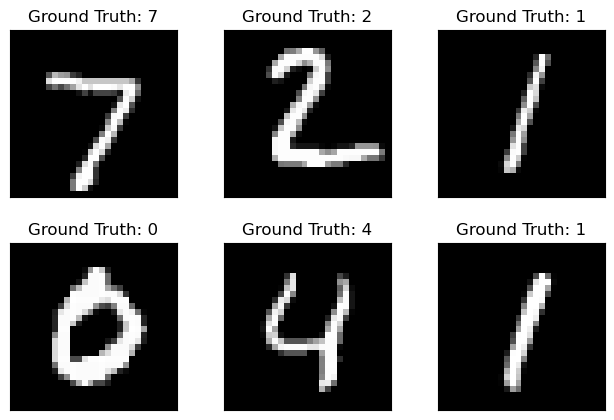

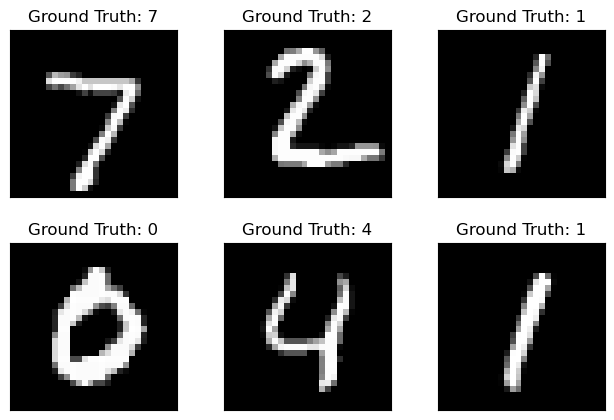

In [6]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Ground Truth: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
fig

Определим класс модели.  

In [7]:
class Net(nn.Module):
    def __init__(self,
                 batchnorm=False,
                 dropout=False,
                 lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        else:
            self.bn = lambda x: x
        if dropout:
            self.dropout = nn.Dropout(0.2)
        else:
            self.dropout = lambda x: x
        self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.bn(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        pred = output.data.max(1, keepdim=True)[1]
        t = target.data.view_as(pred)
        self._correct = pred.eq(t).to(torch.float).mean()
        return self._loss

In [8]:
model = Net(batchnorm=True, dropout=True)
train_log = []
test_log = []

Определим методы для обучения и валидации.  

In [9]:
def train(model, loader, epoch, log=None, device="cpu", frac_size=1.):
    model.to(device)
    stop_idx = int(loader.dataset.data.shape[0] * frac_size) // loader.batch_size
    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        target = target.to(device)
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, target)
        loss.backward()
        model.optim.step()

        if batch_idx == stop_idx:
            break

    line = f"Train Epoch: {epoch}\tLoss: {round(model._loss.item(), 3)}"
    if log is not None:
        log.append((model._loss, model._correct))
    print(line)

In [10]:
def test(model, loader, log=None, device="cpu"):
    model.to(device)
    test_size = len(loader.sampler)
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += model.loss(output, target, reduction='sum')
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= test_size
    correct_pct = correct.to(torch.float) / test_size
    line = f"Test set\tLoss: {round(test_loss.item(), 3)}\tAccuracy: {round(100 * correct_pct.item(), 3)}%\n"
    if log is not None:
        log.append((test_loss, correct_pct))
    print(line)

Проверим активен ли GPU.  

In [11]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device

'cuda:0'

Обучим модель, избегая переобучения, т.е. будем использовать оптимальную архитектуру сети, дропаут и батчнорм.  

In [12]:
for epoch in range(1, 51):
    train(model, train_loader, epoch, train_log, device)
    test(model, test_loader, test_log, device)

Train Epoch: 1	Loss: 2.009
Test set	Loss: 1.98	Accuracy: 48.81%

Train Epoch: 2	Loss: 1.727
Test set	Loss: 1.728	Accuracy: 65.51%

Train Epoch: 3	Loss: 1.383
Test set	Loss: 1.517	Accuracy: 71.74%

Train Epoch: 4	Loss: 1.241
Test set	Loss: 1.338	Accuracy: 75.47%

Train Epoch: 5	Loss: 1.176
Test set	Loss: 1.193	Accuracy: 78.2%

Train Epoch: 6	Loss: 1.136
Test set	Loss: 1.066	Accuracy: 80.06%

Train Epoch: 7	Loss: 0.968
Test set	Loss: 0.968	Accuracy: 81.29%

Train Epoch: 8	Loss: 0.994
Test set	Loss: 0.882	Accuracy: 82.6%

Train Epoch: 9	Loss: 0.952
Test set	Loss: 0.804	Accuracy: 83.9%

Train Epoch: 10	Loss: 0.727
Test set	Loss: 0.746	Accuracy: 84.83%

Train Epoch: 11	Loss: 0.896
Test set	Loss: 0.693	Accuracy: 85.81%

Train Epoch: 12	Loss: 0.658
Test set	Loss: 0.651	Accuracy: 86.31%

Train Epoch: 13	Loss: 0.641
Test set	Loss: 0.611	Accuracy: 86.88%

Train Epoch: 14	Loss: 0.501
Test set	Loss: 0.579	Accuracy: 87.37%

Train Epoch: 15	Loss: 0.446
Test set	Loss: 0.551	Accuracy: 87.6%

Train Epo

Посмотрим на прогресс обучения.  

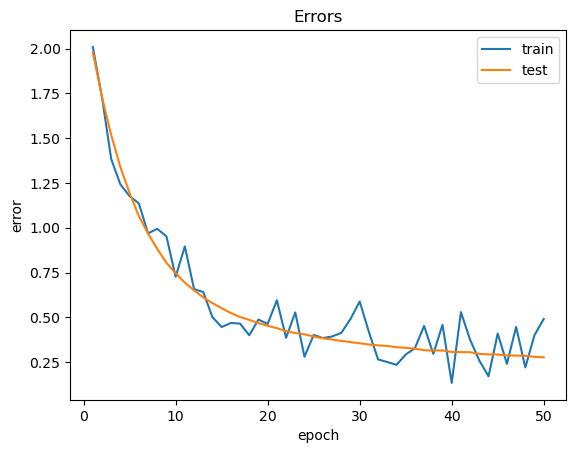

In [13]:
plt.plot([e for e in range(1, len(train_log) + 1)], [t[0].detach().cpu() for t in train_log], label="train")
plt.plot([e for e in range(1, len(test_log) + 1)], [t[0].cpu() for t in test_log], label="test")
plt.title('Errors')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
plt.show()

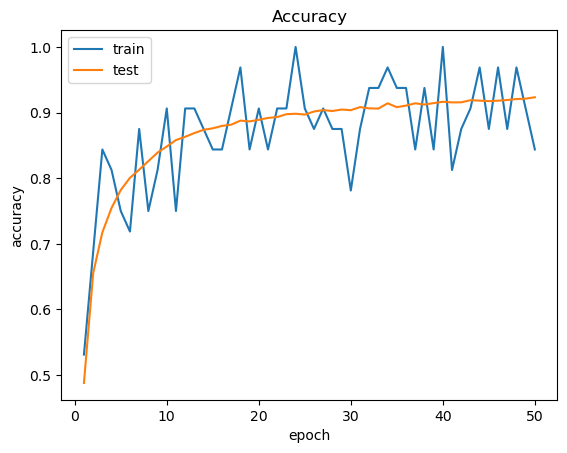

In [14]:
plt.plot([e for e in range(1, len(train_log) + 1)], [t[1].detach().cpu() for t in train_log], label="train")
plt.plot([e for e in range(1, len(test_log) + 1)], [t[1].cpu() for t in test_log], label="test")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Теперь будем добиваться переобучения. Для этого усложним архитектуру и уберем дропаут с батчнорм.  

In [15]:
class OverfittingNet(nn.Module):
    def __init__(self, lr=1e-4, l2=0.):
        super(OverfittingNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self,x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        pred = output.data.max(1, keepdim=True)[1]
        t = target.data.view_as(pred)
        self._correct = pred.eq(t).to(torch.float).mean()
        return self._loss

In [16]:
overfitted_model = OverfittingNet()
overfitted_train_log = []
overfitted_test_log = []

In [17]:
for epoch in range(1, 201):
    train(overfitted_model, train_loader, epoch, overfitted_train_log, device, frac_size=.5)
    test(overfitted_model, test_loader, overfitted_test_log, device)

Train Epoch: 1	Loss: 2.323
Test set	Loss: 2.303	Accuracy: 9.73%

Train Epoch: 2	Loss: 2.298
Test set	Loss: 2.296	Accuracy: 12.05%

Train Epoch: 3	Loss: 2.311
Test set	Loss: 2.29	Accuracy: 14.97%

Train Epoch: 4	Loss: 2.284
Test set	Loss: 2.284	Accuracy: 18.01%

Train Epoch: 5	Loss: 2.258
Test set	Loss: 2.277	Accuracy: 20.92%

Train Epoch: 6	Loss: 2.277
Test set	Loss: 2.27	Accuracy: 23.47%

Train Epoch: 7	Loss: 2.263
Test set	Loss: 2.262	Accuracy: 26.12%

Train Epoch: 8	Loss: 2.241
Test set	Loss: 2.254	Accuracy: 29.67%

Train Epoch: 9	Loss: 2.254
Test set	Loss: 2.246	Accuracy: 33.04%

Train Epoch: 10	Loss: 2.24
Test set	Loss: 2.236	Accuracy: 36.74%

Train Epoch: 11	Loss: 2.229
Test set	Loss: 2.226	Accuracy: 40.77%

Train Epoch: 12	Loss: 2.23
Test set	Loss: 2.215	Accuracy: 44.86%

Train Epoch: 13	Loss: 2.208
Test set	Loss: 2.202	Accuracy: 48.02%

Train Epoch: 14	Loss: 2.186
Test set	Loss: 2.188	Accuracy: 50.72%

Train Epoch: 15	Loss: 2.168
Test set	Loss: 2.173	Accuracy: 53.38%

Train Epo

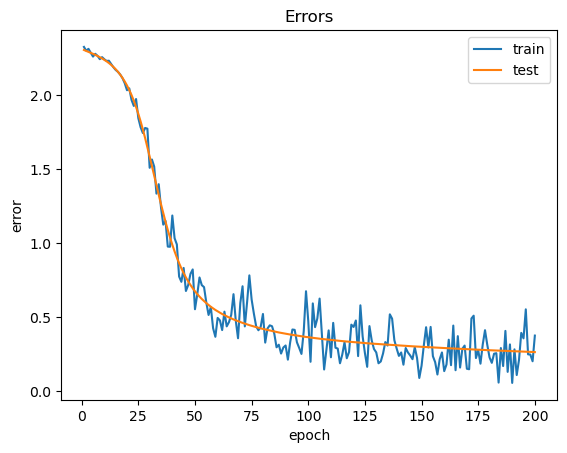

In [18]:
plt.plot([e for e in range(1, len(overfitted_train_log) + 1)], [t[0].detach().cpu() for t in overfitted_train_log], label="train")
plt.plot([e for e in range(1, len(overfitted_test_log) + 1)], [t[0].cpu() for t in overfitted_test_log], label="test")
plt.title('Errors')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
plt.show()

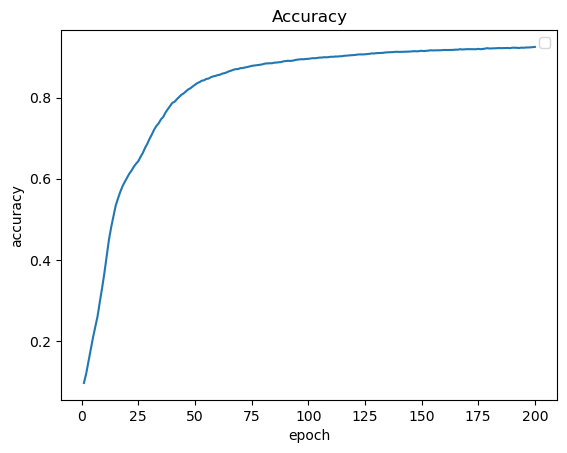

In [19]:
plt.plot([e for e in range(1, len(overfitted_test_log) + 1)], [t[1].cpu() for t in overfitted_test_log])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Колебания лосса показывают, что происходит переобучение. Но модель не может закрепиться в локальных минимумах из-за простоты данных, поэтому обучение все-таки происходит. 